## re-building this hapfreq map without gdal dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects

In [2]:
%run setup.ipynb
%run ../agam-report-base/src/python/ag1k/phase2_ar1.py
%matplotlib inline

### setup data

In [3]:
df_meta = pd.read_csv('../data/samples.meta.txt', sep="\t")
df_meta.rename(columns={"location":"region"}, inplace=True)
df_meta.columns

Index(['ox_code', 'src_code', 'population', 'country', 'region', 'site',
       'contributor', 'contact', 'year', 'm_s', 'sex', 'n_sequences',
       'mean_coverage', 'ebi_sample_acc', 'latitude', 'longitude'],
      dtype='object')

In [4]:
df_haplotypes = pd.read_csv('../data/haplotypes.autosomes.meta.txt', sep='\t')
df_haplotypes['region'] = df_haplotypes['region'].str.replace('_', " ")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Gado-Badzere', "Gado Badzere")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Zembe-Borongo', "Zembe Borongo")
df_haplotypes.head()

,Unnamed: 0,label,ox_code,population,label_aug,country,region,sex,m_s
0,0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
1,1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
2,2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
3,3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
4,4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [5]:
# use the network membership to define haplotype groups
vgsc_clusters = np.load('../data/median_joining_network_membership.npy').astype('U')
clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) 
              for l in np.unique(vgsc_clusters)}
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'FX', 'S1', 'S2', 'S3', 'S4', 'S5', 'SX'])

In [6]:
# merge the "other resistant" groups
clust_dict['OR'] = clust_dict['FX'] | clust_dict['SX']
del clust_dict['FX']
del clust_dict['SX']
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'OR'])

In [7]:
hap_labels = sorted(clust_dict)
# reorder for aesthetics
hap_labels = (
    [l for l in hap_labels if l.startswith('F')] +
    [l for l in hap_labels if l.startswith('S')] +
#     [l for l in hap_labels if l.startswith('L')] +
    ['OR', 'wt']
)
hap_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'OR', 'wt']

In [8]:
def make_df_pops():
    global df_pops

    tbl_pops = (
        etl
        .wrap([
            ['pop', 'long_label', 'short_label', 'query'],
            ['AOcol', 'Angola $coluzzii$', 'AO$Ac$', 'population == "AOcol"'],
            ['GHcol', 'Ghana $coluzzii$', 'GH$Ac$', 'population == "GHcol"'],
            ['BFcol', 'Burkina Faso $coluzzii$', 'BF$Ac$', 'population == "BFcol"'],
            ['CIcol', "Côte d'Ivoire $coluzzii$", 'CI$Ac$', 'population == "CIcol"'],
            ['GNcol', "Guinea $coluzzii$", 'GN$Ac$', 'population == "GNcol"'],
            ['CMgam', 'Cameroon $gambiae$', 'CM$Ag$', 'population == "CMgam"'],
            ['CMgam_savanna', 'Cameroon (savanna) $gambiae$', 'CM$Ag$', 'population == "CMgam" and (region == "Gado Badzere" or region == "Zembe Borongo")'],
            ['CMgam_transition', 'Cameroon (transition) $gambiae$', '', 'population == "CMgam" and region == "Daiguene"'],
            ['CMgam_forest', 'Cameroon (forest) $gambiae$', '', 'population == "CMgam" and region == "Mayos"'],
            ['GHgam', 'Ghana $gambiae$', 'GH$Ag$', 'population == "GHgam"'], 
            ['BFgam', 'Burkina Faso $gambiae$', 'BF$Ag$', 'population == "BFgam"'],
            ['GNgam', 'Guinea $gambiae$', 'GN$Ag$', 'population == "GNgam"'],
            ['GW', 'Guinea-Bissau', 'GW', 'population == "GW"'],
            ['GM', 'The Gambia', 'GM', 'population == "GM"'],
            ['GAgam', 'Gabon $gambiae$', 'GA$Ag$', 'population == "GAgam"'],
            ['UGgam', 'Uganda $gambiae$', 'UG$Ag$', 'population == "UGgam"'],
            ['FRgam', 'Mayotte $gambiae$', 'FR$Ag$', 'population == "FRgam"'],
            ['GQgam', 'Bioko $gambiae$', 'GQ$Ag$', 'population == "GQgam"'],
            ['KE', 'Kenya', 'KE', 'population == "KE"'],      
        ])
        .addfield('latitude', lambda row: df_meta.query(row.query).latitude.mean())
        .addfield('longitude', lambda row: df_meta.query(row.query).longitude.mean())
        .addfield('n_haps', lambda row: len(df_meta.query(row.query)) * 2)
    )

    df_pops = tbl_pops.todataframe()
    df_pops = df_pops.set_index('pop')
    
    
make_df_pops()
df_pops

,long_label,short_label,query,latitude,longitude,n_haps
pop,,,,,,
AOcol,Angola $coluzzii$,AO$Ac$,"population == ""AOcol""",-8.821000,13.291000,156
GHcol,Ghana $coluzzii$,GH$Ac$,"population == ""GHcol""",5.377246,-1.317371,110
BFcol,Burkina Faso $coluzzii$,BF$Ac$,"population == ""BFcol""",11.222600,-4.461400,150
CIcol,Côte d'Ivoire $coluzzii$,CI$Ac$,"population == ""CIcol""",5.898390,-4.822930,142
GNcol,Guinea $coluzzii$,GN$Ac$,"population == ""GNcol""",8.500000,-9.417000,8
CMgam,Cameroon $gambiae$,CM$Ag$,"population == ""CMgam""",4.936394,13.936182,594
CMgam_savanna,Cameroon (savanna) $gambiae$,CM$Ag$,"population == ""CMgam"" and (region == ""Gado Bad...",5.747000,14.442000,192
CMgam_transition,Cameroon (transition) $gambiae$,,"population == ""CMgam"" and region == ""Daiguene""",4.777000,13.844000,192
CMgam_forest,Cameroon (forest) $gambiae$,,"population == ""CMgam"" and region == ""Mayos""",4.341000,13.558000,210


### calculate hap freqs across populations - produce df for plotting

In [9]:
def compute_hap_freqs():
    global df
    
    n_pops = len(df_pops)
    n_haps = len(hap_labels)
    hap_frequencies = np.zeros([n_pops, n_haps], dtype=int)

    # then loop through clusters
    for i, pop in enumerate(df_pops.index):
        pop_query = df_pops.loc[pop].query
        pop_hap_ixs = set(df_haplotypes.query(pop_query).index.values)
        for j, label in enumerate(hap_labels):
            core_hap_ixs = clust_dict[label]
            isec = pop_hap_ixs.intersection(core_hap_ixs)
            hap_frequencies[i, j] = len(isec)


    counts = df_pops.n_haps
    counts

    # make df for plotting
    df = pd.DataFrame(data=hap_frequencies, index=df_pops.index, columns=hap_labels)
    df['other'] = counts - df.sum(axis=1).values
    df['total'] = counts
    df['lon'] = df_pops['longitude']
    df['lat'] = df_pops['latitude']
    
compute_hap_freqs()

#### collapse GN into one pop as GNcol is only 8 haplotypes and they are the same as GNgam

In [10]:
df.loc['GNgam', 'F1'] = 86
df.loc['GNgam', 'other_resistant'] = 1
df.loc['GNgam', 'wt'] = 1
df.loc['GNgam', 'total'] = 88
df.rename(index={'GNgam':'GN'},inplace=True)
df.drop("GNcol", axis=0, inplace=True)

In [11]:
df

,F1,F2,F3,F4,F5,S1,S2,S3,S4,S5,OR,wt,other,total,lon,lat,other_resistant
pop,,,,,,,,,,,,,,,,,
AOcol,111,0,0,0,0,0,0,0,0,0,20,25,0,156,13.291000,-8.821000,NaN
GHcol,90,0,0,0,0,0,0,0,0,0,0,20,0,110,-1.317371,5.377246,NaN
BFcol,123,0,0,0,0,0,0,0,0,0,5,22,0,150,-4.461400,11.222600,NaN
CIcol,125,0,0,0,0,0,0,0,0,0,5,12,0,142,-4.822930,5.898390,NaN
CMgam,28,13,55,23,159,0,8,0,37,42,40,189,0,594,13.936182,4.936394,NaN
CMgam_savanna,2,3,29,12,40,0,1,0,11,14,16,64,0,192,14.442000,5.747000,NaN
CMgam_transition,15,5,18,5,57,0,4,0,10,12,13,53,0,192,13.844000,4.777000,NaN
CMgam_forest,11,5,8,6,62,0,3,0,16,16,11,72,0,210,13.558000,4.341000,NaN
GHgam,24,0,0,0,0,0,0,0,0,0,0,0,0,24,-0.219280,5.668490,NaN


## map fun

In [12]:
crs_lonlat = ccrs.PlateCarree()
ratios = np.asarray([0.5, 0.5])
sum(ratios)

1.0

In [13]:
crs_lonlat = ccrs.PlateCarree()

In [14]:
#drop CM transect
df.drop("CMgam_savanna", axis=0, inplace=True)
df.drop("CMgam_transition", axis=0, inplace=True)
df.drop("CMgam_forest", axis=0, inplace=True)

#### offsets for pies

In [31]:
df.reset_index(inplace=True)
#make lonlat offsets, label position exceptions 
df['offset_lon'] = np.zeros(len(df))
df['offset_lat'] = np.zeros(len(df))
df['label'] = 'top'

#ghana col
df.loc[df['pop'] == 'GHcol', 'offset_lat'] = -3
df.loc[df['pop'] == 'GHcol', 'offset_lon'] = -2.6
#df.loc[df['pop'] == 'GHcol', 'label'] = 'bottom'
#ghana gam
df.loc[df['pop'] == 'GHgam', 'offset_lat'] = -3
df.loc[df['pop'] == 'GHgam', 'offset_lon'] = 2.6
#df.loc[df['pop'] == 'GHgam', 'label'] = 'bottom'
#BFgam
df.loc[df['pop'] == 'BFgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'BFgam', 'offset_lon'] = 2.6
df.loc[df['pop'] == 'BFgam', 'label'] = 'bottom'
#BFcol
df.loc[df['pop'] == 'BFcol', 'offset_lat'] = 3
df.loc[df['pop'] == 'BFcol', 'offset_lon'] = -2.6
df.loc[df['pop'] == 'BFcol', 'label'] = 'bottom'

#Uganda
df.loc[df['pop'] == 'UGgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'UGgam', 'offset_lon'] = 0
df.loc[df['pop'] == 'UGgam', 'label'] = 'bottom'
#Gambia
df.loc[df['pop'] == 'GM', 'offset_lat'] = 0
df.loc[df['pop'] == 'GM', 'offset_lon'] = -3
df.loc[df['pop'] == 'GM', 'label'] = 'bottom'
#GB
df.loc[df['pop'] == 'GW', 'offset_lat'] = -2
df.loc[df['pop'] == 'GW', 'offset_lon'] = -2
#Kenya
df.loc[df['pop'] == 'KE', 'offset_lat'] = -1
df.loc[df['pop'] == 'KE', 'offset_lon'] = 2
df.loc[df['pop'] == 'KE', 'label'] = 'bottom'
#Cam
df.loc[df['pop'] == 'CMgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'CMgam', 'offset_lon'] = 3
df.loc[df['pop'] == 'CMgam', 'label'] = 'bottom'
#mayotte
df.loc[df['pop'] == 'FRgam', 'offset_lat'] = 2
df.loc[df['pop'] == 'FRgam', 'offset_lon'] = -1
df.loc[df['pop'] == 'FRgam', 'label'] = 'bottom'
#Equatorial Guinea
df.loc[df['pop'] == 'GQgam', 'offset_lat'] = -1
df.loc[df['pop'] == 'GQgam', 'offset_lon'] = -2
df.loc[df['pop'] == 'GQgam', 'label'] = 'bottom'
#Angola
df.loc[df['pop'] == 'AOcol', 'offset_lat'] = 0
df.loc[df['pop'] == 'AOcol', 'offset_lon'] = 3
#Gabon
# df.loc[df['pop'] == 'Gabon', 'offset_lat'] = -1.5
# df.loc[df['pop'] == 'Gabon', 'offset_lon'] = 3
df.loc[df['pop'] == 'GAgam', 'offset_lat'] = -2
df.loc[df['pop'] == 'GAgam', 'offset_lon'] = 2.5
#Guinea
df.loc[df['pop'] == 'GN', 'offset_lat'] = 2
df.loc[df['pop'] == 'GN', 'offset_lon'] = -1
df.loc[df['pop'] == 'GN', 'label'] = 'bottom'
# #Guinea
# df.loc[df['pop'] == 'Guinea', 'offset_lat'] = 2
# df.loc[df['pop'] == 'Guinea', 'offset_lon'] = -1
#Cote
df.loc[df['pop'] == "CIcol", 'offset_lat'] = 2
df.loc[df['pop'] == "CIcol", 'offset_lon'] = -2.5
#df.loc[df['pop'] == "CIcol", 'label'] = 'bottom'

In [32]:
df

,level_0,index,pop,F1,F2,F3,F4,F5,S1,S2,...,OR,wt,other,total,lon,lat,other_resistant,offset_lon,offset_lat,label
0,0,0,AOcol,111,0,0,0,0,0,0,...,20,25,0,156,13.291000,-8.821000,NaN,3.0,0.0,top
1,1,1,GHcol,90,0,0,0,0,0,0,...,0,20,0,110,-1.317371,5.377246,NaN,-2.6,-3.0,top
2,2,2,BFcol,123,0,0,0,0,0,0,...,5,22,0,150,-4.461400,11.222600,NaN,-2.6,3.0,bottom
3,3,3,CIcol,125,0,0,0,0,0,0,...,5,12,0,142,-4.822930,5.898390,NaN,-2.5,2.0,top
4,4,4,CMgam,28,13,55,23,159,0,8,...,40,189,0,594,13.936182,4.936394,NaN,3.0,3.0,bottom
5,5,5,GHgam,24,0,0,0,0,0,0,...,0,0,0,24,-0.219280,5.668490,NaN,2.6,-3.0,top
6,6,6,BFgam,183,0,0,0,0,0,0,...,1,0,0,184,-4.371304,11.192065,NaN,2.6,3.0,bottom
7,7,7,GN,86,0,0,0,0,0,0,...,0,1,0,88,-9.692000,8.912500,1.0,-1.0,2.0,bottom
8,8,8,GW,0,0,0,0,0,0,0,...,0,182,0,182,-15.606377,11.914894,NaN,-2.0,-2.0,top
9,9,9,GM,0,0,0,0,0,0,0,...,0,130,0,130,-15.900000,13.550000,NaN,-3.0,0.0,bottom


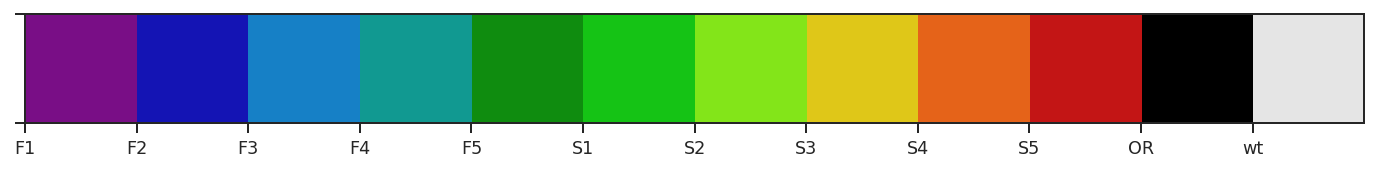

In [33]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

In [34]:
# for legend
f_colors = {l: c for l, c in zip(hap_labels, palette)}
f_colors

{'F1': (0.47488509803921597, 0.05869215686274509, 0.5282294117647058),
 'F2': (0.07882686274509798, 0.07882686274509798, 0.7094417647058824),
 'F3': (0.08667000000000002, 0.5039405882352944, 0.78003),
 'F4': (0.06667000000000001, 0.60003, 0.5686417647058825),
 'F5': (0.061306862745098, 0.5517617647058823, 0.061306862745098),
 'S1': (0.08536215686274506, 0.7682594117647059, 0.08536215686274506),
 'S2': (0.5140988235294116, 0.9, 0.09999999999999998),
 'S3': (0.8752817647058824, 0.781164117647059, 0.09725352941176468),
 'S4': (0.9, 0.39176470588235296, 0.09999999999999998),
 'S5': (0.7682594117647059, 0.08536215686274506, 0.08536215686274506),
 'OR': (0, 0, 0),
 'wt': (0.9, 0.9, 0.9)}

In [42]:
def plot_map(fn=None):
    
    pie_scale_factor=0.02
    subplot_kw = dict(projection=ccrs.PlateCarree())
    # figsize here is the entire figure size in inches, reduced later by bbox_inches
    # This dpi setting affects the display size of the figure in the notebook
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=subplot_kw)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=2, edgecolor='gray')

# def plot_shiny_map(fn=None, dpi=150):
#     subplot_kw = dict(projection=crs_lonlat)
#     fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=subplot_kw)
#     ax.set_extent(extent_lonlat, crs=crs_lonlat)
#     ax.imshow(data, cmap=color_map, extent=extent_lonlat, origin='upper', alpha=0.3)
#     ax.coastlines(resolution='50m', linewidth=1.5, zorder=1)
#     ax.add_feature(cfeature.BORDERS, linewidth=1.5, zorder=4)
    
    
    
        #add pies
    for _, row in df.iterrows():
        ratios = np.asarray([row[k]/row.total for k in hap_labels])
        ratios = np.append(ratios, 1 - np.sum(ratios))
       
        # wedgeprops is used here just to pass the zorder command
        centre = (row.lon + row.offset_lon, row.lat + row.offset_lat)
        #radius = np.sqrt(row.total * .02)
        radius=np.sqrt(row.total * pie_scale_factor)
        
        ax.pie(ratios, wedgeprops=dict(zorder=7, linewidth=0), colors=palette, center=centre, radius=radius, shadow=True)
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=2))

        
        lbl = row['pop']
        if row.label == 'bottom':
            ax.text(centre[0], centre[1] + (radius + (0.1 * radius)), lbl, ha='center', va='bottom', fontsize=12, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
        if row.label == 'top':
            ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), lbl, ha='center', va='top', fontsize=12, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
   
        if row.offset_lat != 0 or row.offset_lon != 0:
            ax.plot([row.lon, row.lon + row.offset_lon],[row.lat, row.lat + row.offset_lat], 'k-', lw=2, zorder=5)
    
        
    #cover tiny island
    plt.plot([-15, -5],[-5, -30], 'w', lw=20, zorder=2)
    ax.set_extent([-22.5, 48.5, -13, 15.5])

    handles = [mpl.patches.Patch(facecolor=f_colors[k], edgecolor='k', label=k) for k in hap_labels]
    leg = ax.legend(handles=handles, bbox_to_anchor=(0, 0), loc='lower left', title="Haplotype group", ncol=4, prop={'size': 10}, frameon=False)
    #leg._legend_box.align = "left"
    #Sample size legend
    plt.text(-15.7, -5, 'Sample size', fontsize=10, fontweight='bold')
    # Markers of same size as circles (below) used for spacing, hidden by alpha
    l1 = Line2D([], [], marker = 'o', markersize=10, markerfacecolor='k', color='k', alpha=0) 
    l2 = Line2D([], [], marker = 'o', markersize=20, markerfacecolor='k', color='k', alpha=0) 
    l3 = Line2D([], [], marker = 'o', markersize=50, markerfacecolor='k', color='k', alpha=0)
    labelz = ["n=50", " n=250", "  n=500"]
    leg = ax.legend([l1, l2, l3], labelz, ncol=3, frameon=False, fontsize=12, handlelength=1, loc=3,
                    borderpad=1.6, handletextpad=1.6, bbox_to_anchor=(-0.05, 0.0))
    #lw=2 to match the circles added around the pies
    ax.add_patch(plt.Circle(xy=(-20,-10.5), radius=np.sqrt(50 * pie_scale_factor), facecolor='k', zorder=12, lw=0))
    ax.add_patch(plt.Circle(xy=(-9,-10.5), radius=np.sqrt(200 * pie_scale_factor), facecolor='k', zorder=12, lw=0))
    ax.add_patch(plt.Circle(xy=(2.8,-10.5), radius=np.sqrt(500 * pie_scale_factor), facecolor='k', zorder=12, lw=0))

    if fn:
        fig.savefig(fn, format="svg",  bbox_inches='tight');

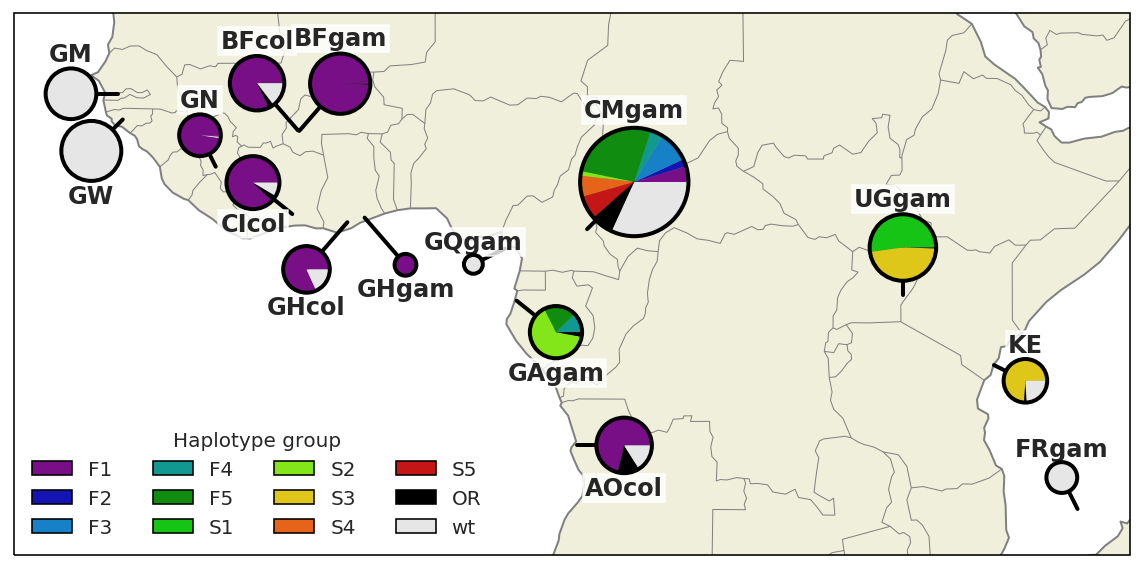

In [40]:
plot_map(fn='../artwork/figure_Phase_2_vgsc_haplotype_frequency_new.svg')

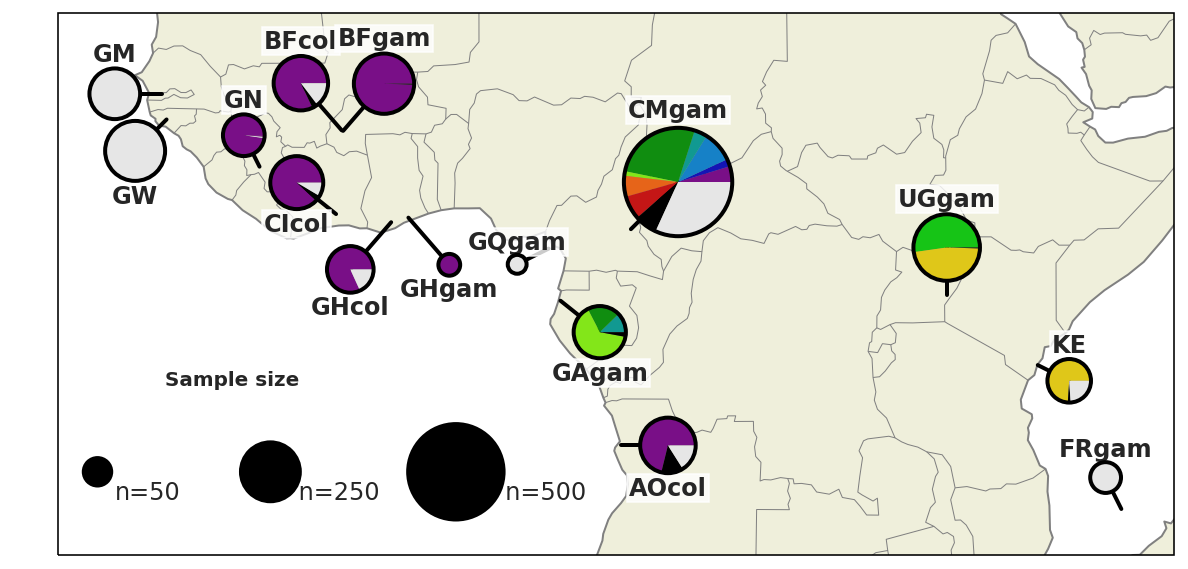

In [45]:
#adds the correctly scaled pies to copy into the plot above in inkscape
plot_map(fn='../artwork/figure_Phase_2_vgsc_haplotype_frequency_pie_legend.svg')